# Softmax Regression from Scratch

Just like we learned how to implement linear regression from scratch, it is very instructive to do the same for softmax regression. After that we'll repeat the same procedure using Gluon for comparison. We begin with our regular import ritual.

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import autograd, nd

We use the Fashion-MNIST data set with batch size 256.

In [2]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)

## Initialize Model Parameters

Just as in linear regression, we use vectors to represent examples. Since each example is an image with $28 \times 28$ pixels we can store it as a $784$ dimensional vector. Moreover, since we have 10 categories, the single layer network has an output dimension of 10. Consequently, the weight and bias parameters of the softmax regression are matrics of size $784 \times 10$ and $1 \times 10$ respectively. We initialize $W$ with Gaussian noise.

In [3]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

As before, we have to attach a gradient to the model parameters.

In [4]:
W.attach_grad()
b.attach_grad()

## The Softmax

Before defining softmax regression let us briefly review how operators such as `sum` work along specific dimensions in an NDArray. Given a matrix `X` we can sum over all elements (default) or only over elements in the same column (`axis=0`) or the same row (`axis=1`). Moreover, we can retain the same dimensionality rather than collapsing out the dimension that we summed over, if required (`keepdims=True`).

In [5]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

We can now define the softmax function. For that we first exponentiate each term using `exp` and then sum each row to get the normalization constant. Last we divide each row by its normalization constant and return the result. Before looking at the code, let's look at this in equation form:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$$

The denominator is sometimes called the partition function (and its logarithm the log-partition function). The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics)) where a related equation models the distribution over an ensemble of particles). Also note that in the definition below we are somewhat sloppy as we do not take any precautions against numerical overflow or underflow due to large (or very small) elements of the matrix, as we did in [Naive Bayes](../chapter_crashcourse/naive-bayes.md).

In [6]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # The broadcast mechanism is applied here.

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability.

In [7]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.21324193 0.33961776 0.1239742  0.27106097 0.05210521]
  [0.11462264 0.3461234  0.19401033 0.29583326 0.04941036]]
 <NDArray 2x5 @cpu(0)>, 
 [1.0000001 1.       ]
 <NDArray 2 @cpu(0)>)

## The Model

With the softmax operation, we can define the softmax regression model discussed in the last section. We change each original image into a vector with length `num inputs` through the `reshape` function.

In [8]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

In the [last section](softmax-regression.md), we introduced the cross-entropy loss function used by softmax regression. It may be the most common loss function you ’ ll find in all of deep learning. That ’ s because at the moment, classification problems tend to be far more abundant than regression problems.

Recall that it picks the label's predicted probability and takes its logarithm $-\log p(y|x)$. Rather than having to do this using a Python `for` loop (which tends to be inefficient) we have a `pick` function which allows us to select the appropriate terms from the matrix of softmax entries easily. We illustrate this in the case of 3 categories and 2 examples.

In [9]:
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2])
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

This yields the cross-entropy loss function.

In [10]:
def cross_entropy(y_hat, y):
    return - nd.pick(y_hat, y).log()

## Classification Accuracy

Given a class of predicted probability distributions `y_hat`, we use the one with the highest predicted probability as the output category. If it is consistent with the actual category `y`, then this prediction is correct.  The classification accuracy is the ratio between the number of correct predictions and the total number of predictions made.

The function `accuracy` is defined as follows: `y_hat.argmax(axis=1)` returns the largest element index to matrix `y_hat`, the result has the same shape as variable `y`. Now all we need to do is check whether both match. Since the equality operator `==` is datatype-sensitive (e.g. an `int` and a `float32` are never equal), we also need to convert both to the same type (we pick `float32`). The result is an NDArray containing entries of 0 (false) and 1 (true). Taking the mean yields the desired result.

In [11]:
#
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

We will continue to use the variables `y_hat` and `y` defined in the `pick` function, as the predicted probability distribution and label, respectively. We can see that the first example's prediction category is 2 (the largest element of the row is 0.6 with an index of 2), which is inconsistent with the actual label, 0. The second example's prediction category is 2 (the largest element of the row is 0.5 with an index of 2), which is consistent with the actual label, 2. Therefore, the classification accuracy rate for these two examples is 0.5.

In [12]:
accuracy(y_hat, y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the data set `data_iter`.

In [13]:
#  The function will be gradually improved: the complete implementation will be
# discussed in the "Image Augmentation" section.
def evaluate_accuracy(data_iter, net):
    acc = 0
    for X, y in data_iter:
        acc += accuracy(net(X), y)
    return acc / len(data_iter)

Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing, i.e. 0.1 for 10 classes.

In [14]:
evaluate_accuracy(test_iter, net)

0.0947265625

## Model Training

The implementation for training softmax regression is very similar to the implementation of linear regression discussed earlier. We still use the mini-batch stochastic gradient descent to optimize the loss function of the model. When training the model, the number of epochs, `num_epochs`, and learning rate `lr` are both adjustable hyper-parameters. By changing their values, we may be able to increase the classification accuracy of the model.

In [15]:
num_epochs, lr = 5, 0.1

#
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum = 0
        train_acc_sum = 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            if trainer is None:
                gb.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)  # This will be illustrated in the next section.
            train_l_sum += l.mean().asscalar()
            train_acc_sum += accuracy(y_hat, y)
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / len(train_iter),
                 train_acc_sum / len(train_iter), test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs,
          batch_size, [W, b], lr)

epoch 1, loss 0.7869, train acc 0.748, test acc 0.806


epoch 2, loss 0.5740, train acc 0.810, test acc 0.825


epoch 3, loss 0.5292, train acc 0.824, test acc 0.827


epoch 4, loss 0.5048, train acc 0.830, test acc 0.838


epoch 5, loss 0.4893, train acc 0.835, test acc 0.842


## Prediction

Now that training is complete, we can show how to classify the image. Given a series of images, we will compare their actual labels (first line of text output) and the model predictions (second line of text output).

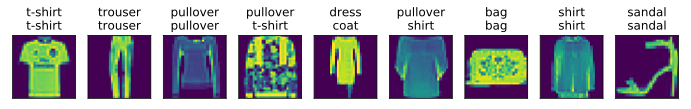

In [16]:
for X, y in test_iter:
    break

true_labels = gb.get_fashion_mnist_labels(y.asnumpy())
pred_labels = gb.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

gb.show_fashion_mnist(X[0:9], titles[0:9])

## Summary

We can use softmax regression to carry out multi-category classification. Training is very similar to that of linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. In fact, most common deep learning models have a similar training procedure.

## Problems

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause (hint - try to calculate the size of $\exp(50)$)?
1. The function `cross_entropy` in this section is implemented according to the definition of the cross-entropy loss function.  What could be the problem with this implementation (hint - consider the domain of the logarithm)?
1. What solutions you can think of to fix the two problems above?
1. Is it always a good idea to return the most likely label. E.g. would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?

## Discuss on our Forum

<div id="discuss" topic_id="2336"></div>